# Usage

An Experiment should have:

    1. Baseline - FULL_0
    2. FULL_attack_ratio
    3. MID_attack_ratio
    4. END_attack_ratio

Place all these in a folder and call ```plot_results()``` method with ```path, model name and attack ratio``` 

In [2]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


def plot_2d(title: str, graph_type: str, baseline: list, full: list, mid: list, end: list):
    plt.title(title)
    rounds = [i for i in range(len(baseline))]
    plt.plot(rounds, baseline, label="Baseline")
    plt.plot(rounds, full, label="FULL")
    plt.plot(rounds, mid, label="MID")
    plt.plot(rounds, end, label="END")
    plt.xlabel("Federated Learning Rounds")
    plt.ylabel(graph_type)
    plt.legend()
    plt.show()


def plot_3d(title: str, graph_type: str, baseline: list, full: list, mid: list, end: list):
    # Assuming you have data in the following format:
    # rounds: List of federated learning rounds
    # baseline_accuracy: List of baseline accuracy values
    # full_100_accuracy: List of accuracy values for FULL attack with 100% label flipping
    # mid_50_accuracy: List of accuracy values for MID attack with 50% label flipping
    # end_30_accuracy: List of accuracy values for END attack with 30% label flipping

#     plt.clf()
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    rounds = [i for i in range(len(baseline))]

    # Plot baseline accuracy
    ax.plot(rounds, [0] * len(rounds), baseline,
            label='Baseline', color='blue', linewidth=2)

    # Plot FULL attack with 100% label flipping
    ax.plot(rounds, [1] * len(rounds), full,
            label='FULL', color='green', linewidth=2)

    # Plot MID attack with 50% label flipping
    ax.plot(rounds, [2] * len(rounds), mid,
            label='MID', color='red', linewidth=2)

    # Plot END attack with 30% label flipping
    ax.plot(rounds, [3] * len(rounds), end,
            label='END', color='purple', linewidth=2)

    # Set labels
    ax.set_xlabel('Federated Learning Rounds')
    # ax.set_ylabel('Label Flipping Intensity')
    ax.set_zlabel(graph_type, rotation=90)
    ax.set_yticks([0, 1, 2, 3])
    # ax.set_yticklabels(['Baseline', 'FULL', 'MID', 'END'])
    ax.set_title(title)

    # Adjust layout to make room for the z-axis label
    ax.set_box_aspect(aspect=None, zoom=0.8)

    # Add legend
    ax.legend()

    # Show the 3D plot
    plt.show()


def plot_other_metrics(title: str, metrics_centralized: dict):
    num_classes = len(metrics_centralized["precision"])
    precision_list = [metrics_centralized["precision"][i][1]
                      for i in range(num_classes)]
    recall_list = [metrics_centralized["recall"][i][1]
                   for i in range(num_classes)]
    f1_list = [metrics_centralized["f1"][i][1] for i in range(num_classes)]

    fig, axs = plt.subplots(2, 2, figsize=(8, 6))
    plt.suptitle(title)

    # Precision
    # plt.subplot(131)
    axs[0, 0].bar(range(num_classes), precision_list, color='blue')
    axs[0, 0].set_xlabel('FL Round')
    axs[0, 0].set_ylabel('Precision')
    axs[0, 0].set_title('Precision')

    # Recall 
    # plt.subplot(132)
    axs[0, 1].bar(range(num_classes), recall_list, color='green')
    axs[0, 1].set_xlabel('FL Round')
    axs[0, 1].set_ylabel('Recall')
    axs[0, 1].set_title('Recall')

    # F1
    # plt.subplot(133)
    axs[1, 0].bar(range(num_classes), f1_list, color='orange')
    axs[1, 0].set_xlabel('FL Round')
    axs[1, 0].set_ylabel('F1-Score')
    axs[1, 0].set_title('F1-Score')


    # TODO Confusion Matrix
    # plt.subplot(1)
    sns.heatmap(metrics_centralized['confusion_matrix'][-1][1],
                fmt="d", cmap="Blues", annot=True,
                xticklabels=range(num_classes),
                yticklabels=range(num_classes), ax=axs[1,1])
    axs[1, 1].set_title("Confusion Matrix")
    axs[1, 1].set_xlabel("Predicted")
    axs[1, 1].set_ylabel("True")

    plt.tight_layout()
    plt.show()



def plot_results(dir: str, model: str, attack_ratio: int, plot_mode: str = '3d'):
    title_dict = {"MLP": "Multi Layer Perceptron",
                  "SCNN": "Simple Convolution Neural Network",
                  "LGR": "Logistic Regression", 
                  "LSVC": "SVC - Linear Kernel",
                  "XGB": "XGBoost"}

    plot_method = None
    if plot_mode == '2d':
        plot_method = plot_2d
    elif plot_mode == '3d':
        plot_method = plot_3d

    title = title_dict[model] + " - " + \
        str(attack_ratio) + "%" + " Adverserial Clients"

    # Baseline 
    file = open(dir + model + "_FULL_0.pkl", 'rb')
    baseline_result = pickle.load(file)
    file.close()
    baseline_loss = baseline_result['history'].losses_centralized
    baseline_accuracy = baseline_result['history'].metrics_centralized['accuracy']
    plot_other_metrics(model + " Baseline - No Adverserial Clients", baseline_result['history'].metrics_centralized)

    # Temporal - FULL 
    file = open(dir + model + "_FULL_" +
                str(attack_ratio) + ".pkl", 'rb')
    full_mal = pickle.load(file)
    file.close()
    full_mal_loss = full_mal['history'].losses_centralized
    full_mal_accuracy = full_mal['history'].metrics_centralized['accuracy']
    plot_other_metrics(title + " (Full)", full_mal['history'].metrics_centralized)

    # Temporal - MID
    file = open(dir + model + "_MID_" +
                str(attack_ratio) + ".pkl", 'rb')
    mid_mal = pickle.load(file)
    file.close()
    mid_mal_loss = mid_mal['history'].losses_centralized
    mid_mal_accuracy = mid_mal['history'].metrics_centralized['accuracy']
    plot_other_metrics(title + " (MID)", mid_mal['history'].metrics_centralized)

    # Temporal - END 
    file = open(dir + model + "_END_" +
                str(attack_ratio) + ".pkl", 'rb')
    end_mal = pickle.load(file)
    file.close()
    end_mal_loss = end_mal['history'].losses_centralized
    end_mal_accuracy = end_mal['history'].metrics_centralized['accuracy']
    plot_other_metrics(title + " (END)", end_mal['history'].metrics_centralized)

    baseline_loss_list = [baseline_loss[i][1]
                          for i in range(len(baseline_loss))]
    full_mal_loss_list = [full_mal_loss[i][1]
                          for i in range(len(full_mal_loss))]
    mid_mal_loss_list = [mid_mal_loss[i][1] for i in range(len(mid_mal_loss))]
    end_mal_loss_list = [end_mal_loss[i][1] for i in range(len(end_mal_loss))]

    plot_method(title, "Loss", baseline_loss_list, full_mal_loss_list,
                mid_mal_loss_list, end_mal_loss_list)

    baseline_accuracy_list = [baseline_accuracy[i][1]
                              for i in range(len(baseline_accuracy))]
    full_mal_accuracy_list = [full_mal_accuracy[i][1]
                              for i in range(len(full_mal_accuracy))]
    mid_mal_accuracy_list = [mid_mal_accuracy[i][1]
                             for i in range(len(mid_mal_accuracy))]
    end_mal_accuracy_list = [end_mal_accuracy[i][1]
                             for i in range(len(end_mal_accuracy))]
    
    print("baseline", "Loss", baseline_loss_list[-1])
    print(model, str(attack_ratio), "FULL", "Loss", full_mal_loss_list[-1])
    print(model, str(attack_ratio), "MID", "Loss", mid_mal_loss_list[-1])
    print(model, str(attack_ratio), "END", "Loss", end_mal_accuracy_list[-1])

    print("baseline", "Accuracy", baseline_accuracy_list[-1])
    print(model, str(attack_ratio), "FULL", "Accuracy", full_mal_accuracy_list[-1])
    print(model, str(attack_ratio), "MID", "Accuracy", mid_mal_accuracy_list[-1])
    print(model, str(attack_ratio), "END", "Accuracy", end_mal_accuracy_list[-1])
    
    
    plot_method(title, "Accuracy", baseline_accuracy_list,
                full_mal_accuracy_list, mid_mal_accuracy_list, end_mal_accuracy_list)


# Label Shifting

## Multi Layer Perceptron

In [ ]:
plot_results("results/LF/", "MLP", 50)

## Simple CNN

In [ ]:
plot_results("results/LF/", "SCNN", 50)

## Logistic Regression

In [ ]:
plot_results("results/LF/", "LGR", 50)

## Linear SVM 

In [ ]:
plot_results("results/LF/", "LSVC", 50)

## XGBoost

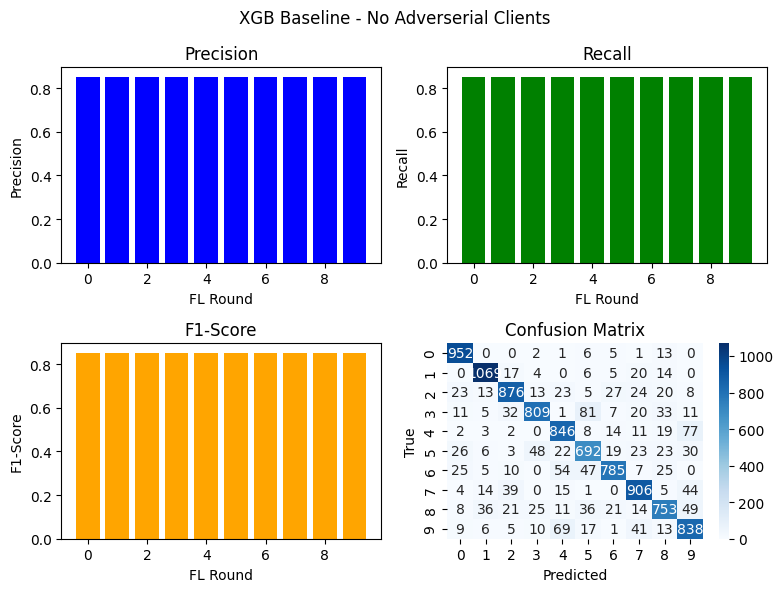

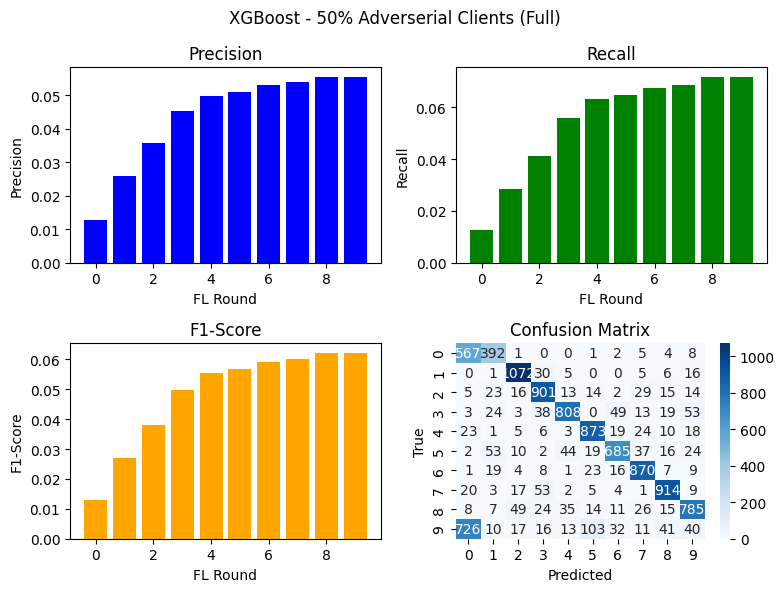

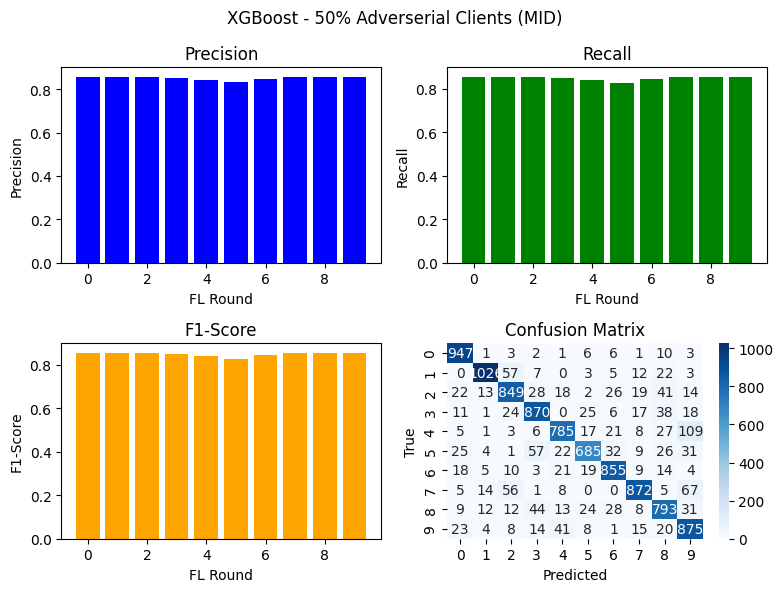

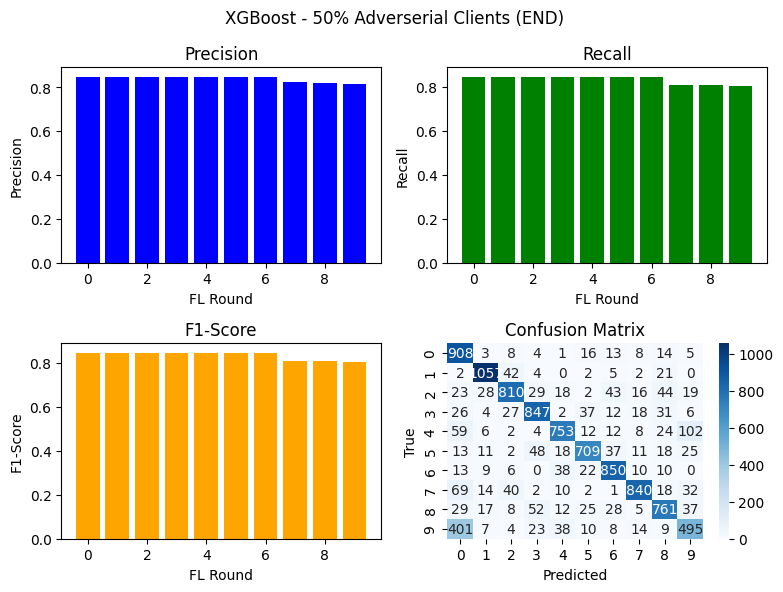

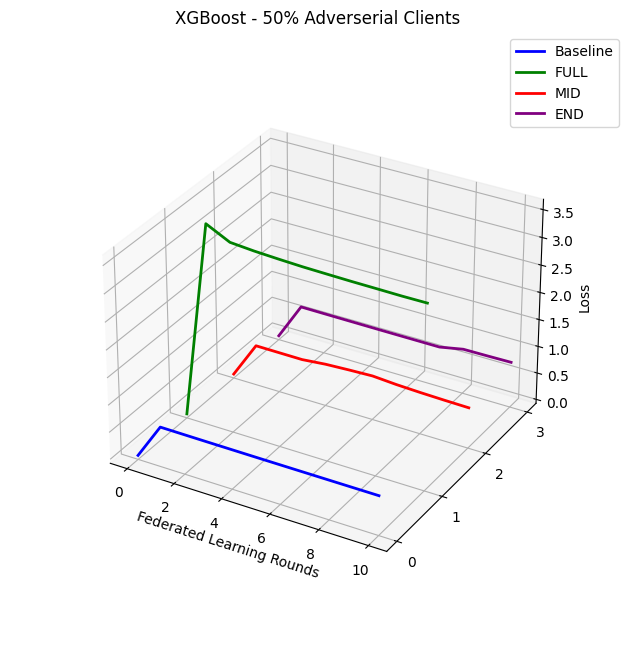

baseline Loss 0.6501629575763364
XGB 50 FULL Loss 3.29987123606503
XGB 50 MID Loss 0.6775521038616076
XGB 50 END Loss 0.803
baseline Accuracy 0.8526
XGB 50 FULL Accuracy 0.0716
XGB 50 MID Accuracy 0.8557
XGB 50 END Accuracy 0.803


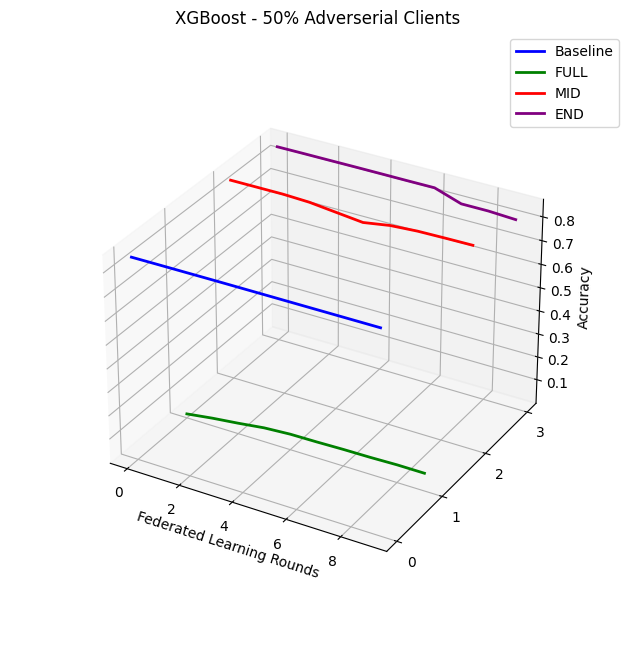

In [3]:
plot_results("results/LF/", "XGB", 50)

# GAN attack 

## Simple CNN 

In [ ]:
plot_results(dir="results/GAN/", model="SCNN", attack_ratio=50)

## Multi Layer Perceptron 

In [ ]:
plot_results(dir="results/GAN/", model="MLP", attack_ratio=50)

## Logistic Regression 

In [ ]:
plot_results(dir="results/GAN/", model="LGR", attack_ratio=50)

## Linear SVC 

In [ ]:
plot_results(dir="results/GAN/", model="LSVC", attack_ratio=50)

## XGBoost

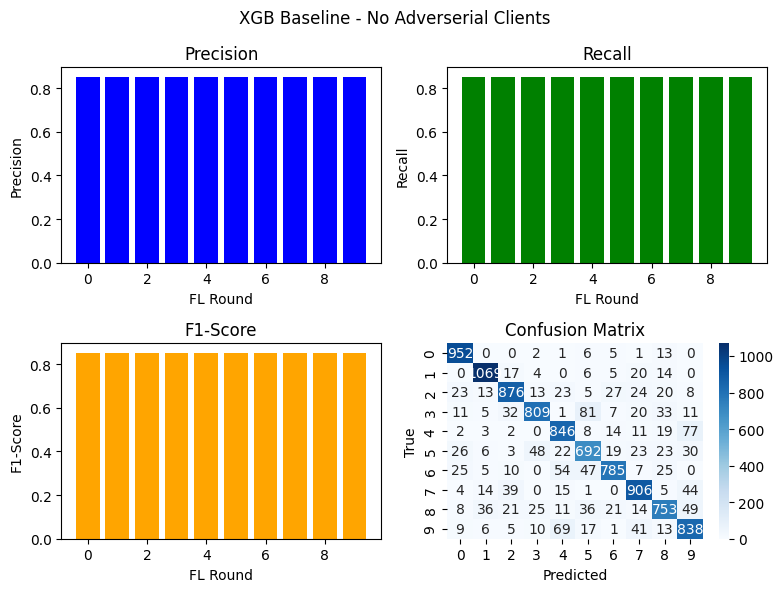

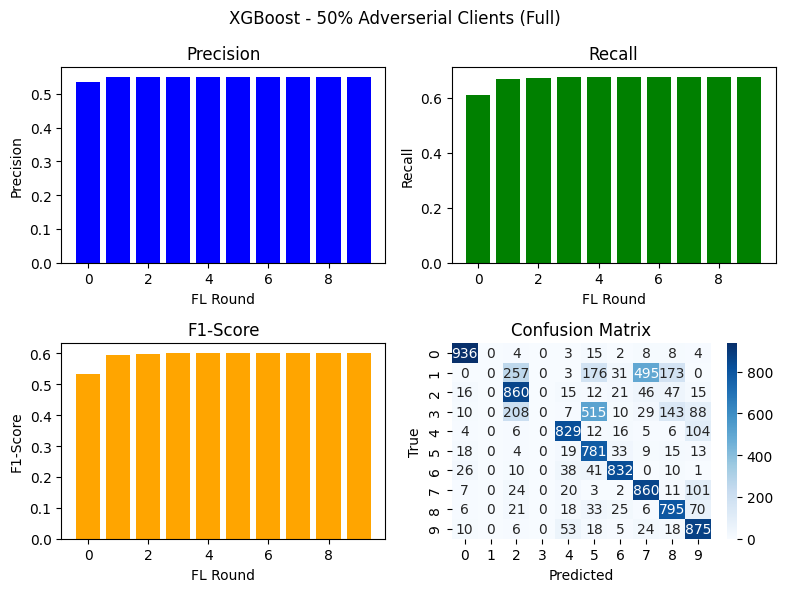

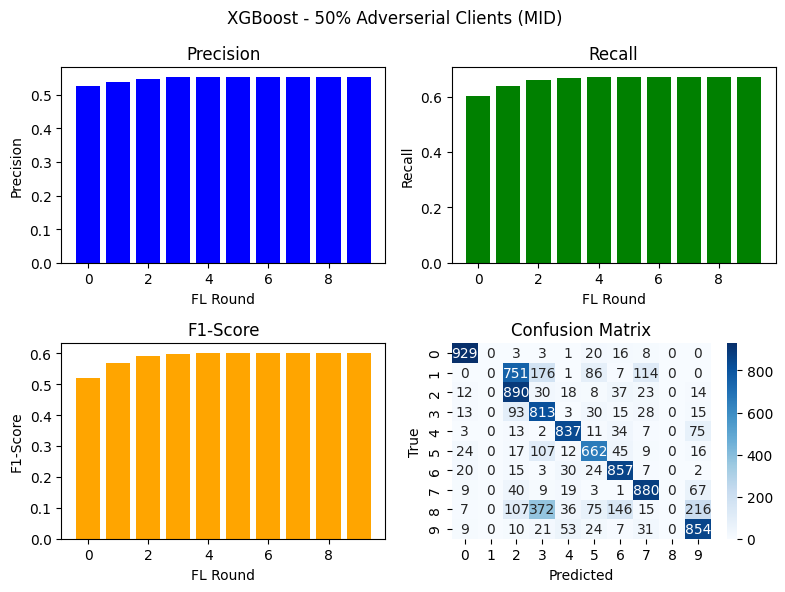

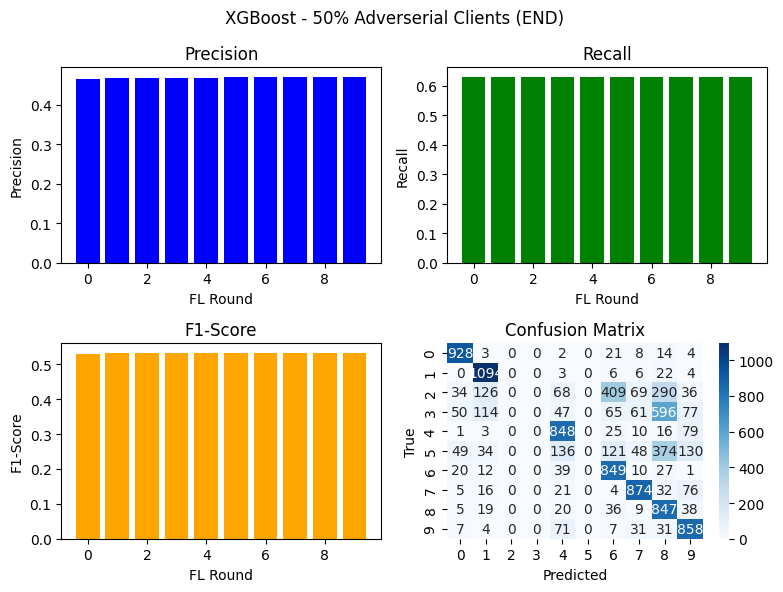

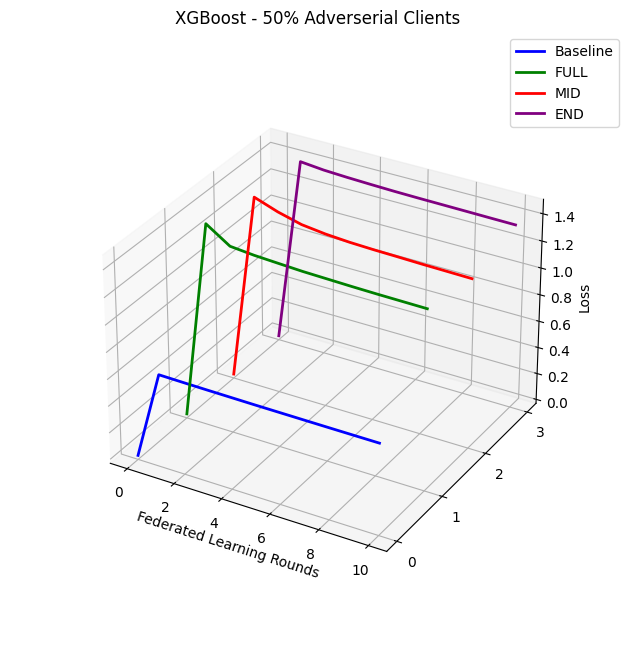

baseline Loss 0.6501629575763364
XGB 50 FULL Loss 1.3084752452230082
XGB 50 MID Loss 1.2343349878042937
XGB 50 END Loss 0.6298
baseline Accuracy 0.8526
XGB 50 FULL Accuracy 0.6768
XGB 50 MID Accuracy 0.6722
XGB 50 END Accuracy 0.6298


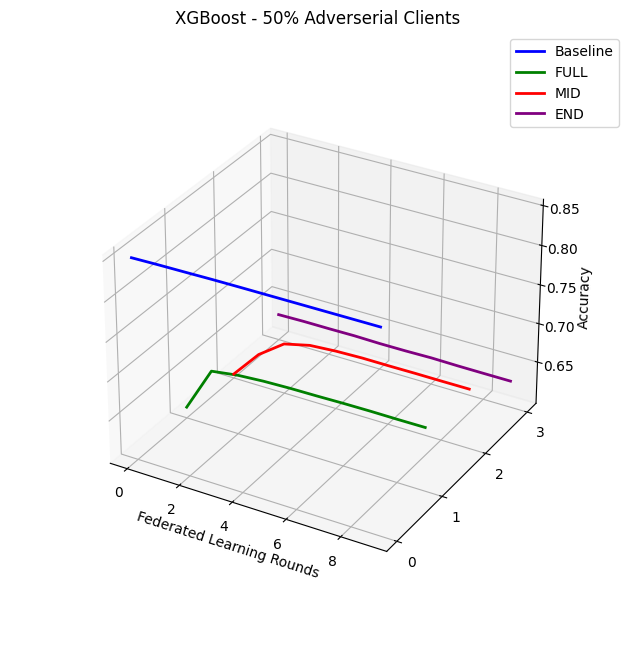

In [4]:
plot_results(dir="results/GAN/", model="XGB", attack_ratio=50)